In [1]:
import ciclo

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

batch_size = 32

ds_train: tf.data.Dataset = tfds.load("mnist", split="train", shuffle_files=True)
ds_train = ds_train.repeat().shuffle(1024).batch(batch_size).prefetch(1)
ds_valid: tf.data.Dataset = tfds.load("mnist", split="test", shuffle_files=True)
ds_valid = ds_valid.batch(batch_size, drop_remainder=True).prefetch(1)

/home/cris/ciclo/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-01-06 17:45:16.209963: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


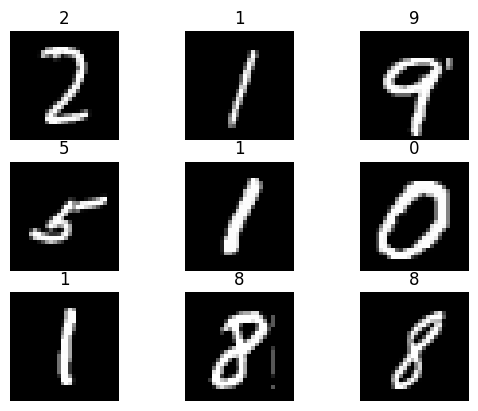

In [3]:
import matplotlib.pyplot as plt

samples = ds_train.as_numpy_iterator().next()
# plot a 3x3 grid of the images using subplots
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(samples["image"][i * 3 + j, :, :, 0], cmap="gray")
        axs[i, j].title.set_text(samples["label"][i * 3 + j])
        axs[i, j].axis("off")

In [4]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
from clu.metrics import Accuracy, Average, Collection
from flax.training import train_state
from flax import struct

class LinearClassifier(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(self.num_classes)(x)
        return x

@struct.dataclass
class Metrics(Collection):
    accuracy: Accuracy
    loss: Average.from_output("loss")

class TrainState(train_state.TrainState):
    metrics: Metrics

def reset_metrics(state):
    return state.replace(metrics=Metrics.empty())
    
def create_state():
    module = LinearClassifier(num_classes=10)
    variables = module.init(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1)))
    return TrainState.create(
        apply_fn=module.apply, 
        params=variables["params"], 
        tx=optax.adam(1e-3),
        metrics=Metrics.empty(),
    )

In [5]:
@jax.jit
def train_step(state, batch):
    inputs, labels = batch['image'], batch['label']

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits, labels
        ).mean()
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    # create logs
    logs = ciclo.logs() # Dict[str, Dict[str, Any]]
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=labels, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    logs.add_stateful_metrics(metrics.compute())

    return logs, state.replace(metrics=metrics)

@jax.jit
def test_step(state, batch):
    inputs, labels = batch['image'], batch['label']

    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits, labels
    ).mean()

    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=labels, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    # create logs
    logs = ciclo.logs() # Dict[str, Dict[str, Any]]
    logs.add_stateful_metrics(metrics.compute())

    return logs, state.replace(metrics=metrics)

In [20]:
total_step = 10_000
state = create_state()

state, history, elapsed = ciclo.loop(
    state,
    ds_train.as_numpy_iterator(),
    {
        ciclo.every(1): train_step,
        ciclo.every(1000, steps_offset=100): [
            reset_metrics,
            ciclo.inner_loop(
                "valid",
                lambda state: ciclo.loop(
                    state,
                    ds_valid.as_numpy_iterator(),
                    {
                        ciclo.every(1): test_step,
                    },
                )
            )
        ],
        **ciclo.keras_bar(total=total_step),
    },
    stop=total_step,
)

10000/10000 [==============================] - 28s 3ms/step - accuracy: 0.8864 - loss: 5.3524 - accuracy_valid: 0.8853 - loss_valid: 5.5725


In [21]:
steps, losses, losses_valid, accs, accs_valid = history.collect("steps", "loss", "loss_valid", "accuracy", "accuracy_valid")

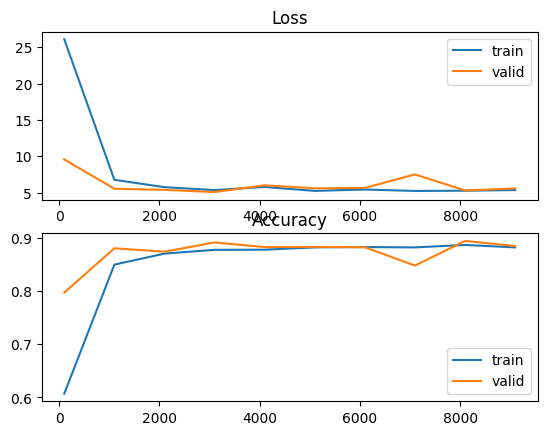

In [22]:
# plot the loss and accuracy
fig, axs = plt.subplots(2, 1)
axs[0].plot(steps, losses, label="train")
axs[0].plot(steps, losses_valid, label="valid")
axs[0].set_title("Loss")
axs[0].legend()
axs[1].plot(steps, accs, label="train")
axs[1].plot(steps, accs_valid, label="valid")
axs[1].set_title("Accuracy")
axs[1].legend()

In [19]:
steps

[2, 1002, 2002, 3002, 4002, 5002, 6002, 7002, 8002, 9002]